# Getting started

The package we will use for our network analysis is `igraph`. There are also other packages out there for Python, such as `networkx` or `graphtool`, but we will not use them during this course. First, we will load all required packages.

In [1]:
# Networks
import igraph as ig
import leidenalg

# Computation
import numpy as np
np.random.seed(0)
import scipy
import random
random.seed(0)

# Data
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Community detection

A common task in network analysis is *community detection*: finding groups of nodes that are relatively densely connected within communities, but sparsely between communities. It provides a sort of birds-eye view of the network, which helps in the interpretation of the network. Communities often seem to share some characteristic (or in for example biological networks, some function).

The method that has been most prominent in the literature is called modularity. It is based on comparing the real network to a random network using the configuration null-model. The idea is that we want to find as many edges within communities compared to the expected number of such edges. Let us illustrate this on the highschool network. We use the recently introduced Leiden algorithm to detect communities.

## Modularity

In [2]:
G = ig.Graph.Read('data/sociopatterns.gml')
G = G.clusters().giant()
G['layout'] = G.layout_fruchterman_reingold(weights='weight')

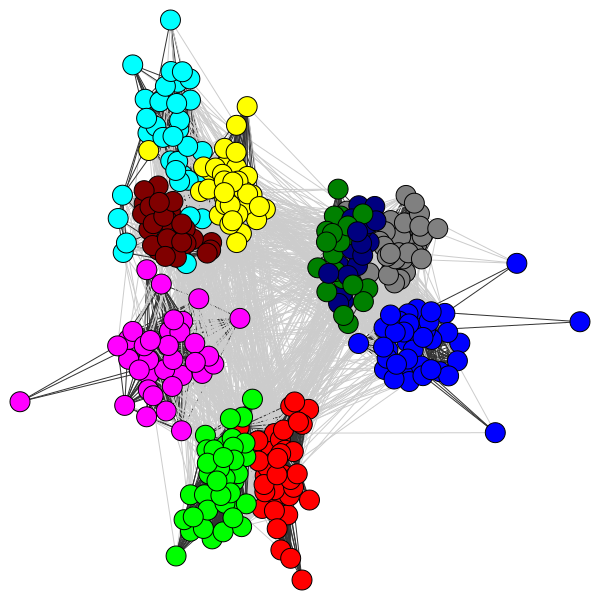

In [5]:
partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition, weights='weight')
ig.plot(partition)

As you can see, modularity finds a number of groups that seems to uncover the classes to some extent. The actual overlap between the two partitions (one partition based on the classes and the other partition based on modularity) can be calculated using something called the *normalised mutual information* (NMI). This value reaches 1 if the two correspond exactly with each other, and reaches 0 if there is no correspondence.

In [6]:
G.vs['modularity'] = partition.membership
class_partition = ig.VertexClustering.FromAttribute(G, 'class')
partition.compare_to(class_partition, 'nmi')

0.9179750130629266

## CPM

Indeed modularity thus seems to uncover the classes quite well. Nonetheless, some classes seem to be split in multiple communities, probably because some social groups within the classes exist. Let us examine one particular class from closer by.

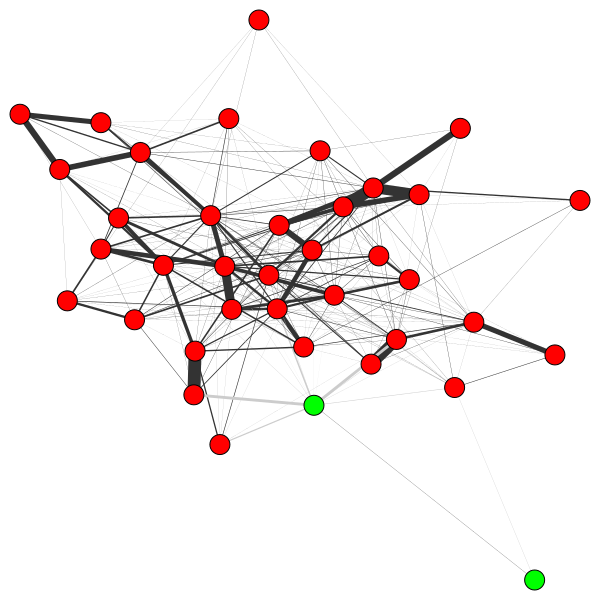

In [7]:
H_class = class_partition.subgraph(4)
H_class['layout'] = H_class.layout_fruchterman_reingold(weights='weight')
H_class.es['width'] = 0.01*np.array(H_class.es['weight'])
partition_of_class = ig.VertexClustering.FromAttribute(H_class, 'modularity')
ig.plot(partition_of_class)

We see that only a few people are not in the same group as the rest of the class. They are also clearly not so much connected to the rest of the class. However, there does seem to be some more particular structure within this group. Let us try modularity again.

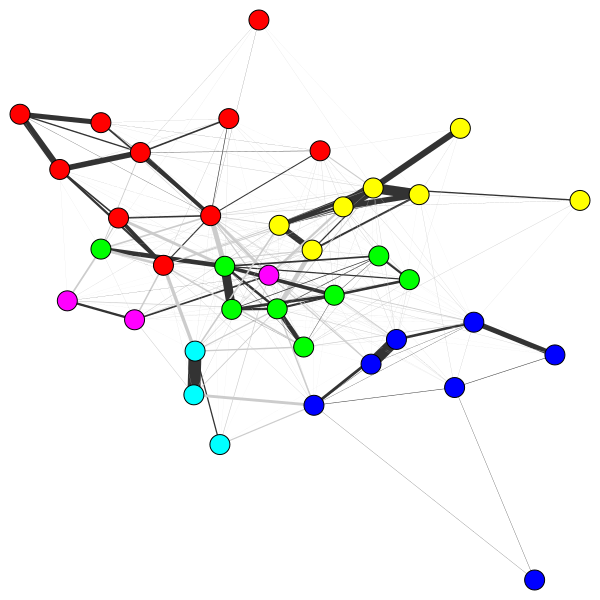

In [8]:
partition_of_class2 = leidenalg.find_partition(H_class, leidenalg.ModularityVertexPartition, weights='weight')
ig.plot(partition_of_class2)

The results are interesting: it suggest there are indeed some smaller groups within the classes. But the definition of 'community' is now no longer clear. What would be called a group at one level (i.e. the class at the overall level of the school) would no longer be considered a group at a lower level, as modularity tends to split it up. This is related to the problem of the *resolution limit* in community detection. Modularity may 'hide' smaller communities, hidden away in the communities it detects.

Both the groups within a class, as well as taking classes as groups themselves would be valid social groups. Clearly they have a relevance in some way. Indeed, what resolution is "better" is not something that has a single unique answer. However, the downside of modularity is that the resolution in a sense depends on the size of the network we are looking at.

We will now investigate another method which does not suffer from this problem, which is called the *Constant Potts Model* (CPM). Although it does require us to choose a resolution parameter, it has a definition of communities that is independent of the size of the network.

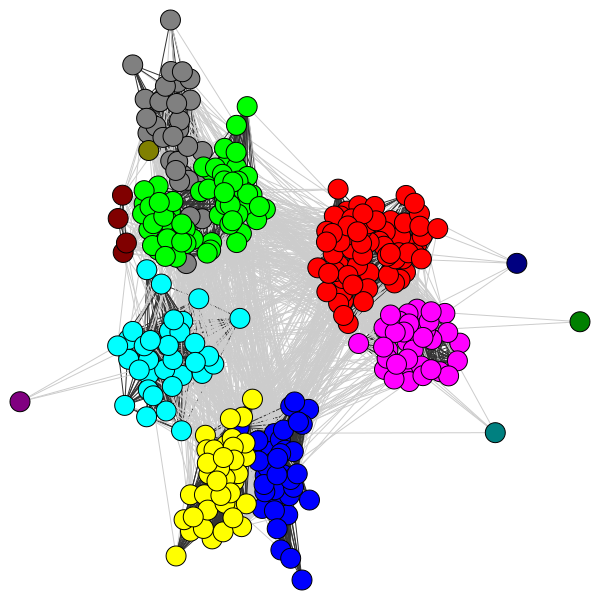

In [9]:
resolution_parameter = 1.15
partition = leidenalg.find_partition(G, leidenalg.CPMVertexPartition, weights='weight', resolution_parameter=resolution_parameter)
ig.plot(partition)

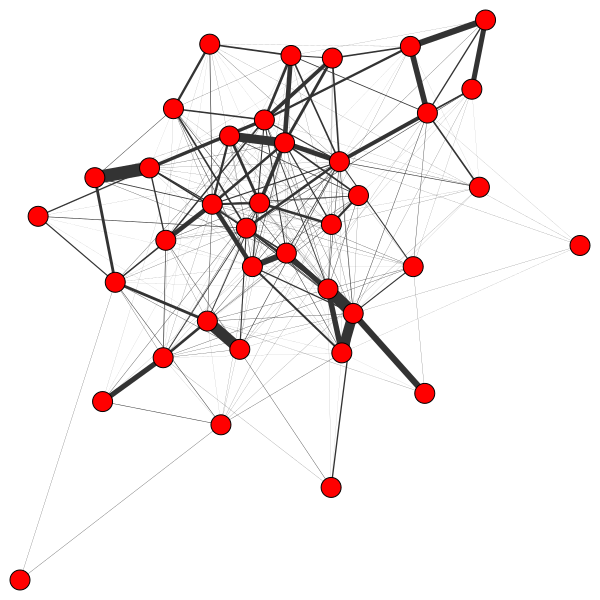

In [11]:
G.vs['CPM'] = partition.membership
H_class = ig.VertexClustering.FromAttribute(G, 'class').subgraph(4)
H_class['layout'] = H_class.layout_fruchterman_reingold(weights='weight')
H_class.es['width'] = 0.01*np.array(H_class.es['weight'])
partition_of_class = ig.VertexClustering.FromAttribute(H_class, 'CPM')
ig.plot(partition_of_class)

CPM finds that this class is completely part of a single community. If we rerun CPM on this particular network, we should find a highly similar community structure.

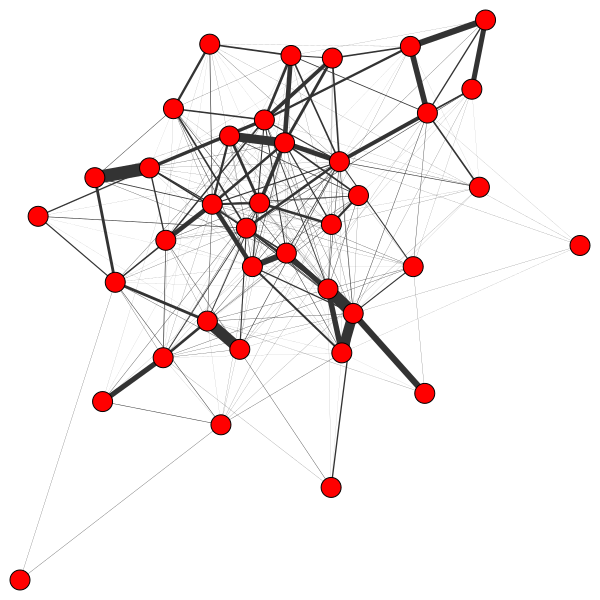

In [12]:
partition_of_class2 = leidenalg.find_partition(H_class, leidenalg.CPMVertexPartition, weights='weight', 
                                             resolution_parameter=resolution_parameter)
ig.plot(partition_of_class2)

Now we could change the resolution parameter if we want to find smaller subgroups within the classes.

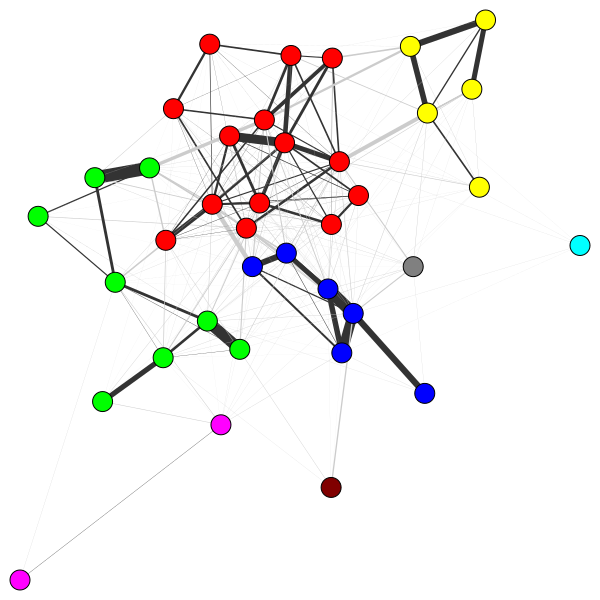

In [13]:
resolution_parameter = 25
partition_of_class2 = leidenalg.find_partition(H_class, leidenalg.CPMVertexPartition, weights='weight', 
                                             resolution_parameter=resolution_parameter)
ig.plot(partition_of_class2)

If we apply this new resolution parameter also at the higher level, we should again get similar results.

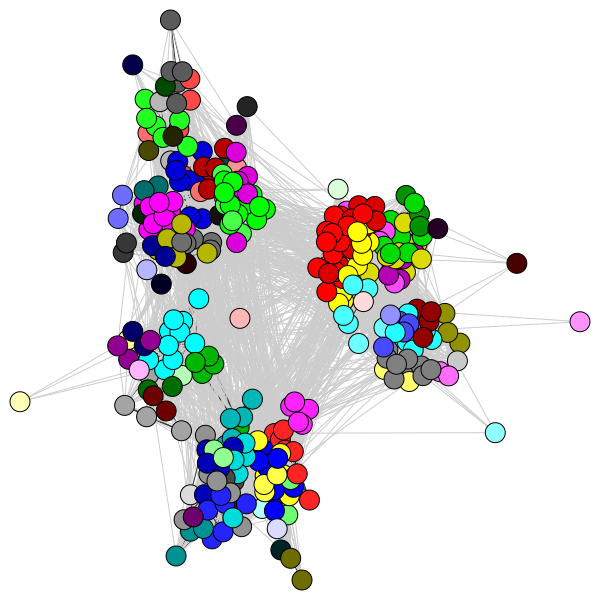

In [14]:
partition = leidenalg.find_partition(G, leidenalg.CPMVertexPartition, weights='weight', resolution_parameter=resolution_parameter)
ig.plot(partition)

Indeed, now each class seems to be partitioned in multiple smaller groups. In other words, the definition of what is a 'community' is independ of whether we look at the level of a single class, or at the level of an entire school.

However, it can be tricky to try to find resolutions that are of interest. It seems impossible to do this automatically without creating problems, so it really depends on your own interpretation of the network and of the results. Nonetheless, there are some tools to help you. One is to construct a so-called *resolution profile*. We simply detect for each resolution within a certain range the partition. This can actually be done reasonably efficiently using bisectioning, which explains also the name of the procedure:

<div class="alert alert-warning">
Constructing a resolution profile may take some time.
</div>

In [16]:
opt = leidenalg.Optimiser()
resolution_profile = opt.resolution_profile(G, leidenalg.CPMVertexPartition, resolution_range=(0, 25), weights='weight')

Let us plot the results, and see how they correspond to to the classes as they are present in the data.

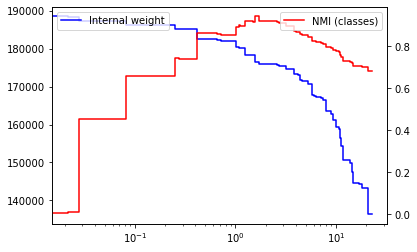

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.step([part.resolution_parameter for part in resolution_profile], 
         [part.total_weight_in_all_comms() for part in resolution_profile], 'blue', label='Internal weight')
ax2.step([part.resolution_parameter for part in resolution_profile], 
         [part.compare_to(class_partition, 'nmi') for part in resolution_profile], 'red', label='NMI (classes)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xscale('log')

This reveals that resolutions somewhere between 0.1 and 0.3 seem to give identical partitions. Hence, a partition in this range is not very sensitive to small changes in the resolution parameter. This might be an indication that there is something of interest at that range.

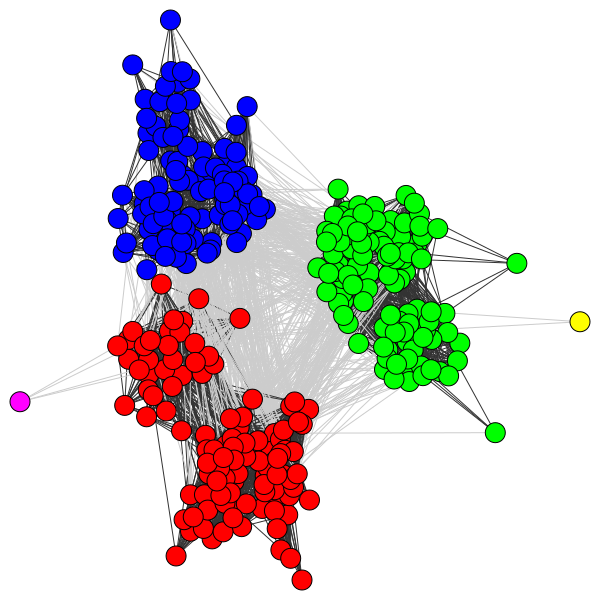

In [18]:
resolution_parameter = 0.2
partition = leidenalg.find_partition(G, leidenalg.CPMVertexPartition, weights='weight', resolution_parameter=resolution_parameter)
ig.plot(partition)

If we take a closer look, we see that the classes can actually be divided in three groups: PC/PSI (Physics & Chemistry/engineering), BIO (biology) and MP (Mathematics & Physics). This suggest that the pupils tend to connect more to other people with a similar educational background or interest.

In [19]:
from collections import Counter
[Counter(H.vs['class']) for H in partition.subgraphs()]

[Counter({'PSI*': 32, 'PC': 44, 'PC*': 39}),
 Counter({'2BIO1': 35, '2BIO2': 34, '2BIO3': 40}),
 Counter({'MP*1': 29, 'MP*2': 38, 'PSI*': 1, 'MP': 33}),
 Counter({'2BIO1': 1}),
 Counter({'PSI*': 1})]

## Negative links

Modularity does not work correct if there are negative weights. However, this can be corrected for. Let us again work with the international relations network.

In [20]:
G = ig.Graph.Read('data/international_relations_2000_2015.gml')

In order to properly detect communities with negative links, we need to split the network into two parts: one with all the positive weights, and one with all the negative weights. Then we want to maximize the number of internal links in the positive network, and minimize the number of internal links in the negative network. This is represented below by the respectively positive and negative `layer_weight`.

In [21]:
G_positive = G.subgraph_edges(G.es.select(weight_gt=0), delete_vertices=False)
G_negative = G.subgraph_edges(G.es.select(weight_lt=0), delete_vertices=False)
G_negative.es['weight'] = -np.array(G_negative.es['weight'])

partition_positive = leidenalg.ModularityVertexPartition(G_positive, weights='weight')
partition_negative = leidenalg.ModularityVertexPartition(G_negative, weights='weight')
opt = leidenalg.Optimiser()
diff = opt.optimise_partition_multiplex([partition_positive, partition_negative], layer_weights=[1.0, -1.0])
mod_partition = ig.VertexClustering(G, membership=partition_positive.membership)

Let us examine the results.

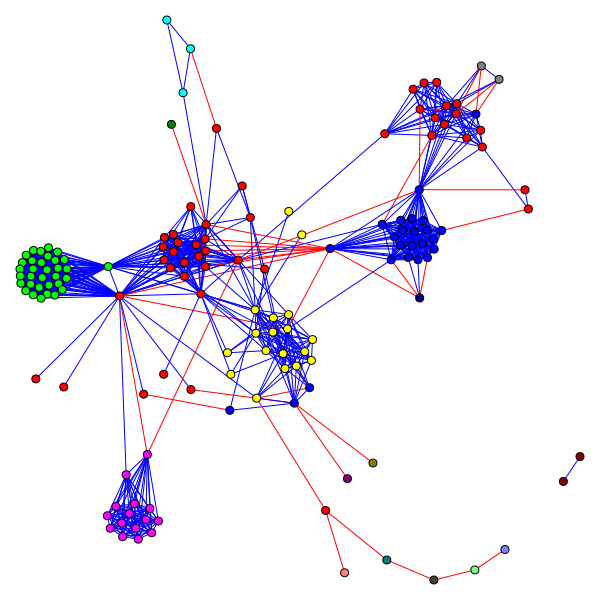

In [22]:
G['layout'] = G.layout_fruchterman_reingold()
ig.plot(mod_partition, vertex_size=8, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in G.es])

Modularity still has some issues with degree. For example, the long paths connected through negative links are sometimes put in the same community. But this is a bit strange, since they should be in separate communities.

Again, CPM seems to work somewhat better in this regard. We can simply work with CPM directly, as it has no problems dealing with negative weights. By setting the resolution parameter to 0, we find communities that are positive connected within, but negatively connected in between. In fact, this corresponds to finding communities that are socially balanced.

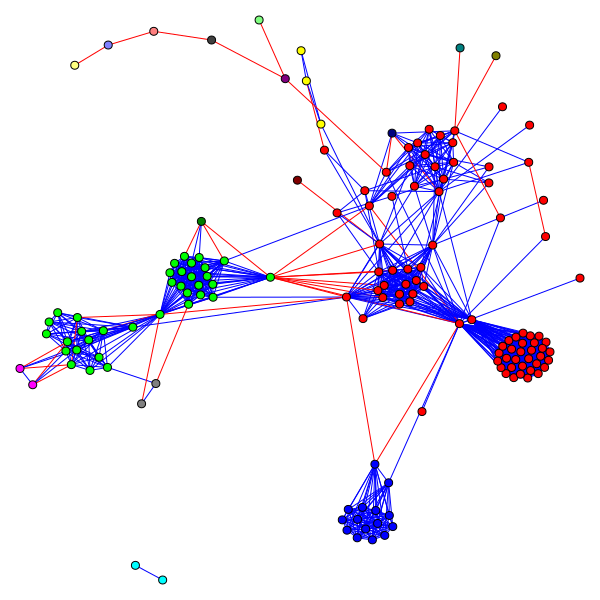

In [49]:
CPM_partition = leidenalg.find_partition(G, leidenalg.CPMVertexPartition, weights='weight', resolution_parameter=0)

G['layout'] = G.layout_fruchterman_reingold()
ig.plot(CPM_partition, vertex_size=8, 
        edge_color=['blue' if e['weight'] > 0 else 'red' for e in G.es])

# Conclusion

This concludes the introduction in the network aspects of computational social science. You can keep this notebook to look up things during the assignment. Also, don't forget you can always can help within the notebook using Shift-Tab and Tab. If you need more help on `igraph`, you can also go to either the [reference manual](http://igraph.org/python/doc/tutorial/tutorial.html) or the [introduction](http://igraph.org/python/doc/tutorial/tutorial.html). Finally, you can always ask one of the lecturers to help you out.